# Summary plots
This notebooks reads all json files of the evaluations, and outputs plots for them. 

In [ ]:
# Load all modules
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from pathlib import Path
import os


In [2]:

def get_summary_results(model_name, level='sent'):
    """
    Reads summary infomration dict from log folder. 
    Inputs:
        model_name: name of the log
        level: either 'sent' (use each sentence seperately) or 'full' (use all
        sentences at once).
    Output:
        results: dict containing summary eval results. 
    """
    if level == 'sent':
        summary_result_path = os.path.join("../logs", model_name, "summary_results_sent.json")
    else:
        summary_result_path = os.path.join("../logs", model_name, "summary_results_full.json")
    with open(summary_result_path, 'r') as JSON:
        results = json.load(JSON)
    return results

model_5 = '5m-mlp_2022-07-21_07-57-47'
model_15 = '15m-mlp_2022-07-05_10-52-12'
model_25 = '25m-mlp_2022-07-05_10-54-42'

results_5 = get_summary_results(model_5)
results_15 = get_summary_results(model_15)
results_25 = get_summary_results(model_25)


### Load baseline results

In [3]:
model_baseline = 'random_model'
results_baseline = get_summary_results(model_baseline)
baseline = np.mean([mrr for mrr in results_baseline['mrrs']])
print(baseline)

0.05236292119898051


### Create BM25 oracle

In [4]:
import torch
from torch import nn, Tensor
from torch.utils import data as datautil
from torch.utils.data import Sampler, BatchSampler, DataLoader
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from dacite import from_dict

import sys
sys.path.append('../') 
from train import mmModule, multimodal_loss, Cfg
from utils import read_metadata_subset, find_paths, relative_file_path, randomize_model
from evaluate_summary import MMloader_summary, summaryEvaluator, get_summ_audio, get_summ_sent_audio

from rank_bm25 import BM25Okapi
from utils import preprocess

from omegaconf import OmegaConf
conf = OmegaConf.load("../config.yaml")

In [5]:
# Rename configurations used, since they are one folder up.
conf.dataset_path = os.path.join("../", conf.dataset_path)
conf.sp_path = os.path.join("../", conf.sp_path)
conf.yamnet_processed_path = os.path.join("../", conf.yamnet_processed_path)
conf.summary_embed_dir = os.path.join("../", conf.summary_embed_dir)
conf.sent_summary_embed_dir = os.path.join("../", conf.sent_summary_embed_dir)

In [6]:
def create_evaluator(model_name):
    """
    Loads an evaluator instance to use for evaluation
    inputs:
         model_name: name of the model log. 
    output: 
        evaluator: evaluator object (see evaluate_summary.py)
    """
    summaries_output_path = os.path.join(conf.dataset_path, 'TREC', 'good_summaries.json')
    sent_summaries_output_path = os.path.join(conf.dataset_path, 'TREC', 'sent_summaries.json')

    ## Read dictionary with summaries
    with open(summaries_output_path, 'r') as f:
        summary_dict = json.load(f)
    with open(sent_summaries_output_path, 'r') as f:
        sent_summary_dict = json.load(f)

    model_weights_path = os.path.join("../logs", model_name, "output", "full_model_weights.pt")
    model_config_path = os.path.join("../logs", model_name, "config.json")

    # Opening JSON file
    f = open(model_config_path)
    model_config = json.load(f)
    fullcfg = from_dict(data_class=Cfg, data=model_config)
    fullcfg.device = "cuda" if torch.cuda.is_available() else "cpu"
    fullcfg.sp_path = conf.sp_path

    # Create dataloader
    data_loader = MMloader_summary(fullcfg, directory=conf.yamnet_processed_path, lin_sep=True)

    # Load the model
    full_model = mmModule(fullcfg)
    full_model.load_state_dict(torch.load(model_weights_path,  map_location=fullcfg.device))        
    full_model = full_model.to(fullcfg.device)     
    full_model.eval()

    # Get yamnet embeddings
    summary_audio_dict = get_summ_audio(conf.summary_embed_dir)
    sent_summary_audio_dict = get_summ_sent_audio(conf.sent_summary_embed_dir)

    # Create evaluator en encode episodes and summaries
    evaluator = summaryEvaluator(fullcfg, None, full_model, data_loader)
    evaluator.encode_summaries(summary_dict, summary_audio_dict)
    evaluator.encode_summaries_sentlevel(sent_summary_dict, sent_summary_audio_dict)
    
    return evaluator
    
evaluator = create_evaluator(model_5)


[spDataset] found 1 h5py files
[spdataset] loading 0/1: ../../data/yamnet/processed/test_summary/embeds.h5


In [21]:

def bm25_evaluation(evaluator):
    """
    Performs bm25 evaluation.
    input: 
        evaluator: evaluator object
    output:
        results: a dict containing evaluation results of bm25. 
    """

    targets = evaluator.sent_summ_targets
    texts = evaluator.sent_summ_texts
    
    corpus = preprocess(texts)
    bm25 = BM25Okapi(corpus)
    k= len(evaluator.sent_summ_texts)

    rank = []        
    mrr = []
    results = {}
    estimates = []
    
    
    for idx in range(len(targets) - 1):
        cur_summary = texts[idx]
        target = targets[idx].split("_")[0]
        cur_summary = preprocess([cur_summary])[0]

        doc_scores = bm25.get_scores(cur_summary)
        top_n_idx = np.argsort(doc_scores)[-k:][::-1]
        indices = top_n_idx
        
        predicted_segs = list(dict.fromkeys([targets[i] for i in indices]))
        predicted_epis = list(dict.fromkeys([i.split("_")[0] for i in predicted_segs]))
 
        estimates.append(predicted_epis.index(target))
    
        rank.append(predicted_epis.index(target))
        mrr.append(1 / (predicted_epis.index(target) + 1))
        
    best_estimation = np.min(estimates)
    rank.append(best_estimation)
    mrr.append(1 / (best_estimation + 1))
    
    results['names'] = 'bm25'
    results['ranks'] = np.mean(rank)
    results['ranks_sd'] = np.std(rank)
    results['mrr'] = np.mean(mrr)
    results['mrr_sd'] = np.std(mrr)
    return results
    
    
results_bm25 = bm25_evaluation(evaluator)


## Plot results with baseline

In [15]:
def plot_results_difbaseline(r5, r15, r25, name='sim', baselines=[0.0, 0.0, 0.0, 0.0], oracle=0.85):
    """
    Plots the results of the summary evaluation, baseline, and oracle
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    offset = 0.3
    width = 0.25

    ax.set_title('Summary ranking', fontsize=20)
    ax.yaxis.grid(False)
    ax.set_ylabel("MRR", fontsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    names = r5['names']
    names = ['text-text', 'text-audio', 'audio-text', 'audio-audio']
    name_vals =np.arange(len(names))
    ax.bar(x=name_vals + (-1*offset), height=r5['mrrs'], yerr=r5['mrrs_sd'], width=width, ecolor='black', color='salmon', alpha=0.8, label="5M")
    ax.bar(x=name_vals + (0*offset), height=r15['mrrs'], yerr=r15['mrrs_sd'], width=width, ecolor='black', color='indianred', alpha=0.8, label="15M")
    ax.bar(x=name_vals + (1*offset), height=r25['mrrs'], yerr=r25['mrrs_sd'], width=width, ecolor='black', color='darkred', alpha=0.8,  label="25M")

    ax.set_xticks(name_vals, names)
    plt.xticks(fontsize=14,rotation=0)

    for idx, b in enumerate(baselines):
        by = [b] * 2
        bx = [-0.5, 0.5]
        bx = [b + idx for b in bx]
        if idx == 0:
            plt.plot(bx, by, label="Random (baseline)", color='royalblue')
        else:
            plt.plot(bx, by, color='darkblue')
    
    oracle = [oracle]* (len(names) + 2)
    x = [-0.5] + np.arange(len(names)).tolist() + [len(names)-0.5]
    plt.plot(x, oracle, label="BM25 (oracle)", color='goldenrod')

    # Save the figure and show
    plt.legend(loc='center right',  bbox_to_anchor=(1.0,0.8), fontsize=12)
    plt.tight_layout()
    plt.savefig('plots/summary/base_{}.pdf'.format(name))
    plt.show()


### Results GRU 

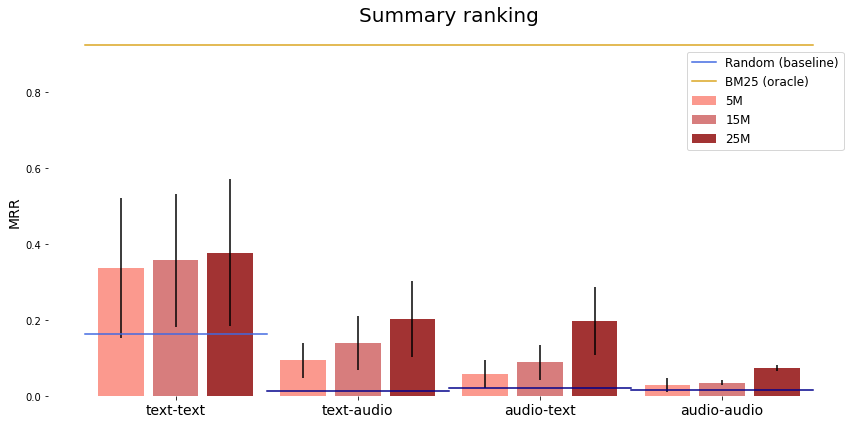

In [16]:

model_baseline = 'random_model'
results_baseline = get_summary_results(model_baseline)

model_5 = '5m-gru_2022-07-21_07-57-25'
model_15 = '15m-gru_2022-07-16_17-00-32'
model_25 = '25m-gru_2022-07-06_07-25-51'

results_5 = get_summary_results(model_5)
results_15 = get_summary_results(model_15)
results_25 = get_summary_results(model_25)

plot_results_difbaseline(results_5, results_15, results_25,'gru', results_baseline['mrrs'], results_bm25['mrr'])
    
    

### Results MLP 


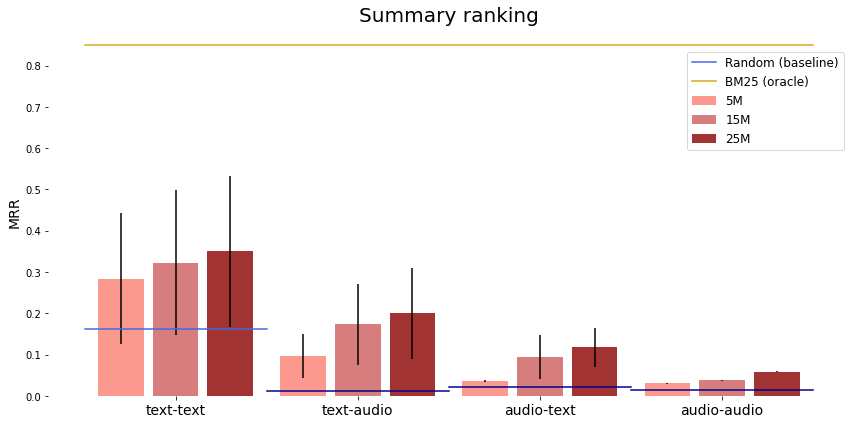

In [17]:

model_baseline = 'random_model'
results_baseline = get_summary_results(model_baseline)

model_5 = '5m-mlp_2022-07-21_07-57-47'
model_15 = '15m-mlp_2022-07-05_10-52-12'
model_25 = '25m-mlp_2022-07-05_10-54-42'

results_5 = get_summary_results(model_5)
results_15 = get_summary_results(model_15)
results_25 = get_summary_results(model_25)

plot_results_difbaseline(results_5, results_15, results_25, name='mlp', baselines=results_baseline['mrrs'])
    
    

### Results SPH

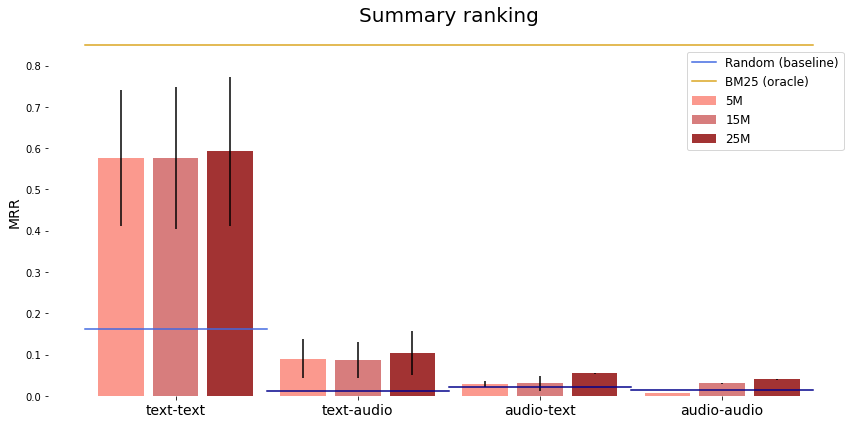

In [18]:
model_baseline = 'random_model'
results_baseline = get_summary_results(model_baseline)

model_5 = '5m-sph_2022-07-20_07-33-19'
model_15 = '15m-sph_2022-07-19_18-10-51'
model_25 = '25m-sph_2022-07-16_19-44-36'

results_5 = get_summary_results(model_5)
results_15 = get_summary_results(model_15)
results_25 = get_summary_results(model_25)


plot_results_difbaseline(results_5, results_15, results_25, name='sph', baselines=results_baseline['mrrs'])
    
    

## Comparison natural readers en google TTS

In [19]:

model_5 = '5m-gru_2022-07-21_07-57-25'
model_15 = '15m-gru_2022-07-16_17-00-32'
model_25 = '25m-gru_2022-07-06_07-25-51'

results_5_google = get_summary_results(model_5, level='full')
results_15_google = get_summary_results(model_15, level='full')
results_25_google = get_summary_results(model_25, level='full')

In [20]:
print(results_25_google)
print(results_25)

{'names': ['fullsummtext2text', 'fullsummtext2audio', 'fullsummaudio2text', 'fullsummaudio2audio'], 'ranks': [67.83018867924528, 126.20754716981132, 232.03773584905662, 635.433962264151], 'ranks_sd': [13944.857956568168, 41277.824848700606, 87646.97970808117, 759365.264506942], 'mrrs': [0.2779522135359352, 0.14155882690684163, 0.06857000103386607, 0.018052631237427532], 'mrrs_sd': [0.15261745108965996, 0.07476537019407113, 0.04281561436433486, 0.004681829415199839]}
{'names': ['sentsummtext2text', 'sentsummtext2audio', 'sentsummaudio2text', 'sentsummaudio2audio'], 'ranks': [24.58490566037736, 281.4339622641509, 659.5471698113207, 3006.698113207547], 'ranks_sd': [5977.865432538272, 450728.01922392304, 1322546.3609825564, 60618067.79565682], 'mrrs': [0.5920676491918817, 0.10262947745121388, 0.05463488171371392, 0.0398402075886129], 'mrrs_sd': [0.17995894753749328, 0.053174010053345974, 0.0009375937063343087, 0.0012057788384616875]}
